# Make crops, not war

In [20]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from src.plots import country_in_war

%matplotlib inline

sns.set_style('whitegrid')

# add time converter for matplotlib visualisation
pd.plotting.register_matplotlib_converters()

In [21]:
prep_data_path = '../pandas_dfs/'

merged_data_file = 'merged_data.csv'
wars_file = 'final_wars_df.csv'
years_per_country_file = 'years_per_country.csv'

merged_crops_data = pd.read_csv(prep_data_path + merged_data_file)
wars_df = pd.read_csv(prep_data_path + wars_file)
years_per_country = pd.read_csv(prep_data_path + years_per_country_file)

First, let us change some names which are different among the dataframes:

In [22]:
merged_crops_data.loc[merged_crops_data['country'] == 'Viet Nam', 'country'] = 'Vietnam'
merged_crops_data.loc[merged_crops_data['country'].str.contains('Syria'), 'country'] = 'Syria'
merged_crops_data.loc[merged_crops_data['country'] == 'Sudan (former)', 'country'] = 'Sudan'
merged_crops_data.loc[merged_crops_data['country'] == 'Russian Federation', 'country'] = 'Russia'
merged_crops_data.loc[merged_crops_data['country'] == 'USSR', 'country'] = 'Soviet Union'
merged_crops_data.loc[merged_crops_data['country'] == "Lao People's Democratic Republic", 'country'] = 'Laos'

In [23]:
merged_crops_data.corr()

,value_crop,value_livestock,value_population,value_land_area
value_crop,1.000000,0.777054,0.889221,0.762014
value_livestock,0.777054,1.000000,0.874261,0.791917
value_population,0.889221,0.874261,1.000000,0.689464
value_land_area,0.762014,0.791917,0.689464,1.000000


Even though there is no correlation at the country level, among production and population and land area, there is still a quite strong general one. Thus we can try to normalize production according to population and land area. 

In [24]:
norm_factor = merged_crops_data['value_population'] * merged_crops_data['value_land_area']
merged_crops_data['norm_value_crop'] = merged_crops_data['value_crop'] / norm_factor
merged_crops_data['norm_value_livestock'] = merged_crops_data['value_livestock'] / norm_factor

avg_production_per_country = (
    merged_crops_data
        .groupby('country')
        .mean()
        .drop(['value_crop', 'value_livestock', 'value_population', 'value_land_area'], axis=1)
        .reset_index()
)

avg_production_per_country

,country,norm_value_crop,norm_value_livestock
0,Afghanistan,0.011558,0.041100
1,Albania,0.581650,1.017409
2,Algeria,0.009232,0.018848
3,American Samoa,60.165591,1.652843
4,Angola,0.009132,0.007849
...,...,...,...
215,Western Sahara,0.003364,0.196400
216,Yemen,0.010243,0.038251
217,Yugoslav SFR,0.106129,0.045730
218,Zambia,0.023572,0.019827


In [28]:
avg_production_years_in_war = (
    avg_production_per_country
        .merge(years_per_country, on='country', how='left')
        .dropna()
)


In [29]:
avg_production_years_in_war.head()

,country,norm_value_crop,norm_value_livestock,years
0,Afghanistan,0.011558,0.041100,28.0
2,Algeria,0.009232,0.018848,27.0
4,Angola,0.009132,0.007849,57.0
7,Armenia,0.486339,0.268927,7.0
10,Azerbaijan,0.130057,0.225317,7.0


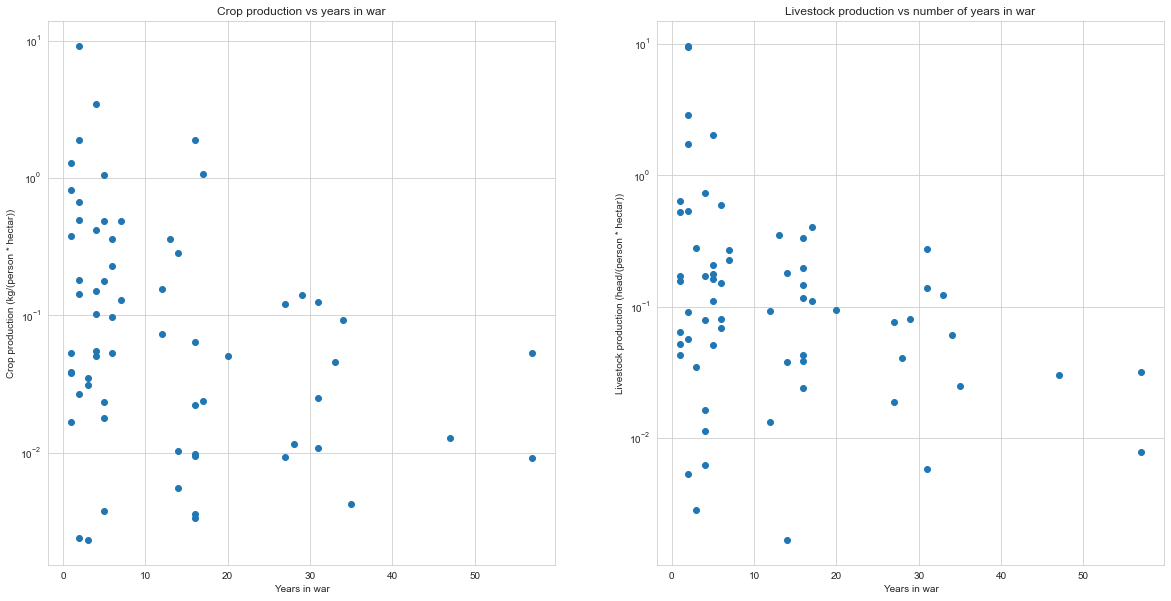

In [30]:
years_in_war = avg_production_years_in_war['years']
mean_crops = avg_production_years_in_war['norm_value_crop']
mean_livestock = avg_production_years_in_war['norm_value_livestock']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(years_in_war, mean_crops, marker='o', linestyle='None')
ax[0].set_title('Crop production vs years in war')
ax[0].set_ylabel('Crop production (kg/(person * hectar))')
ax[0].set_xlabel('Years in war')
ax[0].set_yscale('log')

# for i, txt in enumerate(avg_production_years_in_war['country']):
#    ax[0].annotate(txt, (years_in_war[i], mean_crops[i]))

ax[1].plot(years_in_war, mean_livestock, marker='o', linestyle='None')
ax[1].set_title('Livestock production vs number of years in war')
ax[1].set_ylabel('Livestock production (head/(person * hectar))')
ax[1].set_xlabel('Years in war')
_ = ax[1].set_yscale('log')

In [31]:
afghanistan_crops = (
    merged_crops_data[merged_crops_data['country'] == 'Afghanistan']
        .drop(['norm_value_crop', 'norm_value_livestock', 'value_population', 'value_land_area', 'value_livestock'], axis=1)
)

afghanistan_in_war = country_in_war(wars_df, afghanistan_crops, 'Afghanistan')

afghanistan_in_war

,year,value_crop,in_war
0,1961-01-01,5909080.0,False
1,1962-01-01,5934534.0,False
2,1963-01-01,5686583.0,False
3,1964-01-01,6147934.0,False
4,1965-01-01,6274668.0,False
5,1966-01-01,6041771.0,False
6,1967-01-01,6587527.0,False
7,1968-01-01,6724021.0,False
8,1969-01-01,6902583.0,False
9,1970-01-01,6175993.0,False
